In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [27]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [39]:
# run this ceil for different data sets

α = [1.0, 2.0] # single index for x
θ = [2.0, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 400
fx = 1 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5


# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  1.534266 seconds (1.63 M allocations: 12.158 GiB, 19.44% gc time)
Estimation of index coefs: 
̂α => [0.39860483455043977; 0.9171227757901429]
̂γ => [0.12295941588188866, 0.30607330854578196]
Estimation of linear coefs: 
̂θ => [2.1851255960153915 -0.9497110416009885]
̂β => [-0.7283534200314661, -0.26361548924245326]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

In [7]:
model1.index

Dict{Vector{Float64}, Vector{Int64}} with 4 entries:
  [1.0, 0.0] => [1, 4, 6, 7, 10, 17, 19, 20, 22, 23  …  373, 376, 379, 384, 386…
  [0.0, 1.0] => [16, 40, 43, 44, 55, 69, 73, 109, 117, 122  …  324, 345, 347, 3…
  [1.0, 1.0] => [9, 15, 51, 62, 63, 70, 71, 76, 77, 78  …  321, 323, 335, 336, …
  [0.0, 0.0] => [2, 3, 5, 8, 11, 12, 13, 14, 18, 21  …  377, 378, 380, 382, 383…

In [40]:
g = zeros(n)
dg = zeros(n)
v = X * alpha1 
yz = y - X * transpose(theta)
categ, index = model1.categ, model1.index
z = collect(index)
ncateg = index.count
width = zeros(ncateg)
v0 = -1e6
v1 = 1e6

for k in 1:ncateg
    vk = v[z[k][2]]
    h = (length(vk))^(-0.17) * var(vk)
    width[k] = h

    dgk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 1, τ)
    gk(u) = qgplsim.Gz(u, vk, yz[z[k][2]], 0, τ)

    dg[z[k][2]] = dgk(vk)
    g[z[k][2]] = gk(vk)

    vkmin = minimum(vk) + h
    vkmax = maximum(vk) - h

    if  vkmin > v0
        v0 = vkmin
    end
    if  vkmax < v1
        v1 = vkmax
    end  
end

# g, dg = qgplsim.G(v, Z, yz, τ, -0.4) # g: g(v), dg: g'(v)

println(width)
# v0, v1 = v0 + h, v1 - h
v0, v1

[1.0453018111678276, 0.9167643153566665, 1.5379662639821758, 1.139368588867379]


(-1.6936137620714489, 2.5492971452558413)

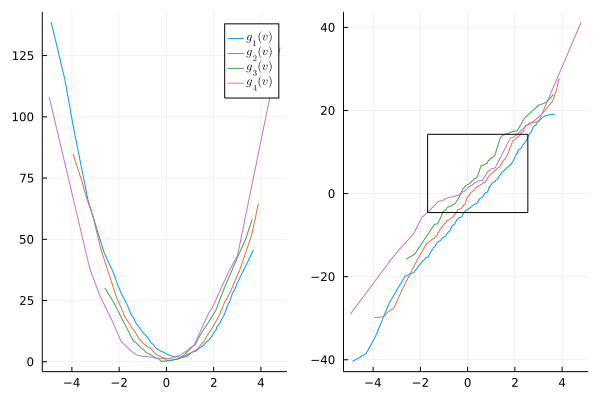

In [41]:
C0 = zeros(ncateg)
C1 = zeros(ncateg)
dgf(vv, k) = qgplsim.Gz(vv, v[z[k][2]], yz[z[k][2]], 1, τ)


p1 = plot()
p2 = plot()
for m in 1:ncateg
    C0[m] = dgf(v0, m)[1]
    C1[m] = dgf(v1, m)[1]

    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]
    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")
    plot!(p2, sorted_vm, sorted_dgm, label = false )# L"\nabla g_{%$m} (v)")

end

c0 = maximum(C0)
c1 = minimum(C1)
plot!(p2, [v0, v0], [c0, c1], color = "black", label = false)
plot!(p2, [v1, v1], [c0, c1], color = "black", label = false)
plot!(p2, [v0, v1], [c0, c0], color = "black", label = false)
plot!(p2, [v0, v1], [c1, c1], color = "black", label = false)


plot(p1, p2, layout = (1,2))

In [173]:
[C0 C1]

4×2 Matrix{Float64}:
 -0.020623   2.20933
  0.0952253  2.07785
 -0.116579   2.32559
 -0.106289   1.94253

# Monte Carlo Simulation

In [175]:
Threads.nthreads()

2

In [42]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [48]:
α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [-1.0, -0.5] # linear for z
τ = 0.5
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 400
fx = 2
dist = 1 # Cauchy
rep = 200 # MC rept. times

200

In [49]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, τ, fx, dist, rep)

0.0%┣                                             ┫ 0/200 [00:00<00:-10, -0s/it]
0.5%┣▏                                         ┫ 1/200 [00:02<Inf:Inf, InfGs/it]
1.0%┣▌                                              ┫ 2/200 [00:03<10:48, 3s/it]
1.5%┣▊                                              ┫ 3/200 [00:05<07:23, 2s/it]
2.0%┣█                                              ┫ 4/200 [00:06<06:14, 2s/it]
2.5%┣█▏                                             ┫ 5/200 [00:07<05:44, 2s/it]
3.0%┣█▍                                             ┫ 6/200 [00:09<05:40, 2s/it]
3.5%┣█▋                                             ┫ 7/200 [00:10<05:37, 2s/it]
4.0%┣█▉                                             ┫ 8/200 [00:12<05:26, 2s/it]
4.5%┣██▏                                            ┫ 9/200 [00:13<05:16, 2s/it]
5.0%┣██▎                                           ┫ 10/200 [00:15<05:07, 2s/it]
5.5%┣██▌                                           ┫ 11/200 [00:16<04:56, 2s/it]
6.0%┣██▊                    

([0.8434873276920574 0.5371490743014568; 0.9885935457356173 0.15060810512678235; … ; 0.9187859007446348 0.3947562141282515; 0.5130847231397099 0.8583379677496781], [0.31630139269563273 0.6833682454695882; 0.3036123951577824 0.6703785046954316; … ; 0.9765838541209338 0.5029214970507933; 0.4470381943706822 0.3243306115682123], [0.6233583911796551 -0.97886216085232; 0.14390779891862024 -0.9446126493139718; … ; 0.43086820374993345 -1.0028357161110844; 0.9731005387447825 -0.5816858152249161], [-0.4004385812650649 0.004608967814108497; -0.2708163467895831 -0.009357146574557657; … ; -0.23259422153595014 0.21041271242456164; -0.7200633807444007 -0.11105129104461282])

In [45]:
mb = mean(Beta, dims = 1)

1×2 Matrix{Float64}:
 -0.388375  -0.0374924

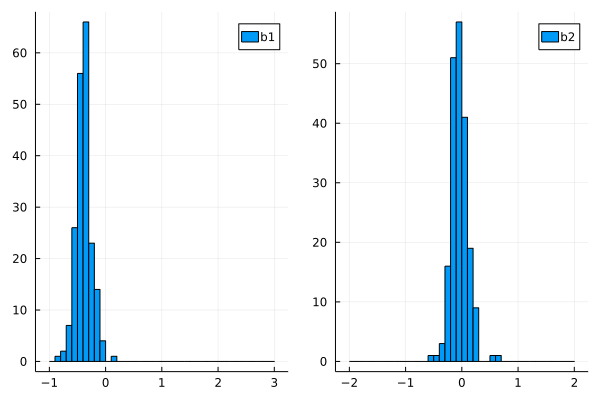

In [46]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -2:0.1:2, label = "b2")
plot(p1, p2, layout = (1, 2))

In [47]:
mg = mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.459904  0.929028

In [197]:
(γ |> transpose) ./ mg

1×2 Matrix{Float64}:
 2.13107  2.21011

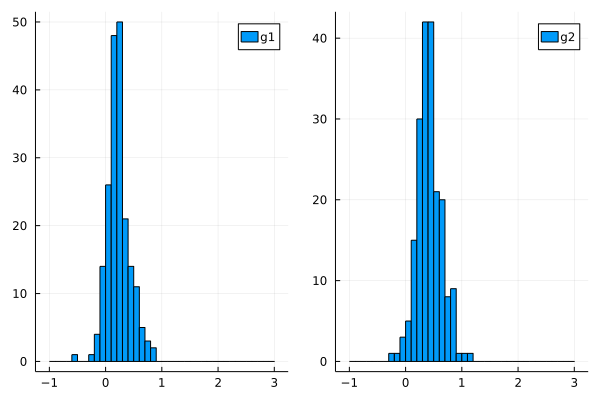

In [191]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [157]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.878183  0.451094

In [158]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 0.511953  -0.969122

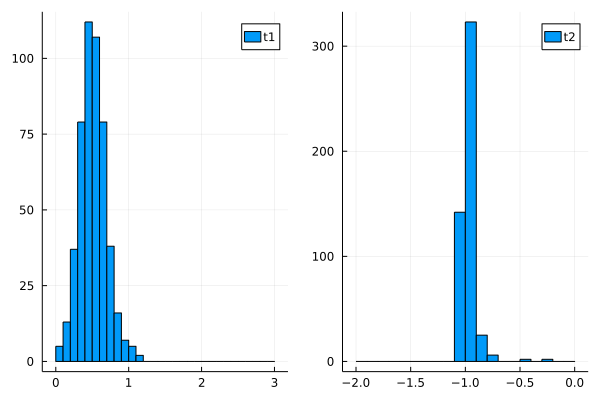

In [159]:
p1 = histogram(Theta[:,1], bins = 0:0.1:3, label = "t1")
p2 = histogram(Theta[:,2], bins = -2:0.1:-0, label = "t2")
plot(p1, p2, layout = (1, 2))

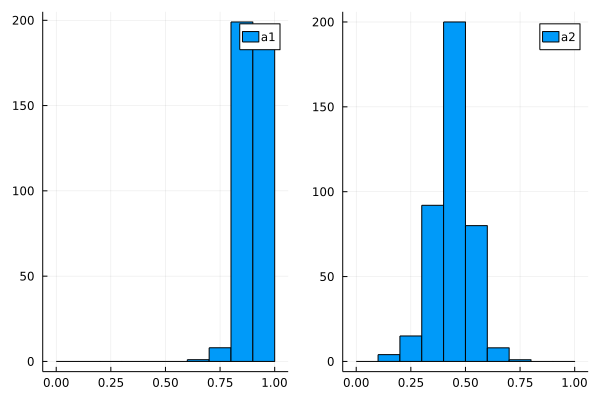

In [349]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))

In [373]:
mg * sqrt(5)

1×2 Matrix{Float64}:
 0.540775  1.10552